<a href="https://colab.research.google.com/github/sgsakthiganesh/GENAI_LAB_PROJECT/blob/main/MPOX_FINAL1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pathlib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from  tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Directories
base_dir = "/content/drive/MyDrive/NEW_MONKEY_DATA"
positive_dir = os.path.join(base_dir, "Positive")
negative_dir = os.path.join(base_dir, "Negative")

# Output directories
train_dir = os.path.join(base_dir, "Train")
val_dir = os.path.join(base_dir, "Validation")
test_dir = os.path.join(base_dir, "Test")

# Create subdirectories
for split in [train_dir, val_dir, test_dir]:
    os.makedirs(os.path.join(split, "Positive"), exist_ok=True)
    os.makedirs(os.path.join(split, "Negative"), exist_ok=True)

# Function to split and move files
def split_and_copy(source_dir, train_dest, val_dest, test_dest):
    files = os.listdir(source_dir)
    train_files, temp_files = train_test_split(files, test_size=0.3, random_state=42)
    val_files, test_files = train_test_split(temp_files, test_size=0.5, random_state=42)

    # Copy files
    for f in train_files:
        shutil.copy(os.path.join(source_dir, f), train_dest)
    for f in val_files:
        shutil.copy(os.path.join(source_dir, f), val_dest)
    for f in test_files:
        shutil.copy(os.path.join(source_dir, f), test_dest)

# Split Positive images
split_and_copy(positive_dir,
               os.path.join(train_dir, "Positive"),
               os.path.join(val_dir, "Positive"),
               os.path.join(test_dir, "Positive"))

# Split Negative images
split_and_copy(negative_dir,
               os.path.join(train_dir, "Negative"),
               os.path.join(val_dir, "Negative"),
               os.path.join(test_dir, "Negative"))

print("Dataset split and organized!")


Dataset split and organized!


In [23]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Directories
train_dir = "/content/drive/MyDrive/NEW_MONKEY_DATA/Train"
val_dir = "/content/drive/MyDrive/NEW_MONKEY_DATA/Validation"
test_dir = "/content/drive/MyDrive/NEW_MONKEY_DATA/Test"

# Image dimensions and batch size
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # MobileNet-specific preprocessing
    horizontal_flip=True,
    zoom_range=0.3,
    rotation_range=20,
    vertical_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2
)

val_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Load data
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'  # Binary classification
)

val_data = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_data = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False  # Keep consistent for evaluation
)


Found 1014 images belonging to 2 classes.
Found 216 images belonging to 2 classes.
Found 222 images belonging to 2 classes.


In [24]:
import os

base_dir = "/content/drive/MyDrive/NEW_MONKEY_DATA"
subsets = ["Train", "Validation", "Test"]
categories = ["Positive", "Negative"]

# Count images in each subset and category
for subset in subsets:
    print(f"\n{subset.upper()} SET:")
    for category in categories:
        dir_path = os.path.join(base_dir, subset, category)
        count = len(os.listdir(dir_path))
        print(f"  {category}: {count} images")


TRAIN SET:
  Positive: 400 images
  Negative: 632 images

VALIDATION SET:
  Positive: 85 images
  Negative: 136 images

TEST SET:
  Positive: 87 images
  Negative: 136 images


In [27]:
from tensorflow.keras.applications import MobileNetV2,VGG16, VGG19, InceptionV3, Xception, ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D,BatchNormalization

base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights="imagenet")

base_model.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(1024, activation=keras.layers.LeakyReLU(negative_slope=0.01)),
    Dropout(0.3),
    Dense(512, activation=keras.layers.LeakyReLU(negative_slope=0.01)),
    Dropout(0.3),
    Dense(256, activation=keras.layers.LeakyReLU(negative_slope=0.01)),
    Dropout(0.2),
    Dense(128, activation=keras.layers.LeakyReLU(negative_slope=0.01)),
    Dropout(0.2),
    Dense(64, activation=keras.layers.LeakyReLU(negative_slope=0.01)),
    Dropout(0.1),
    Dense(32, activation=keras.layers.LeakyReLU(negative_slope=0.01)),
    Dropout(0.1),
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

call_back=tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3, verbose=1, restore_best_weights=True)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 1024)                │       1,311,744 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,269,121 (16.29 MB)

 Trainable params: 2,011,137 (7.67 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [20]:
import os
from PIL import Image

def clean_image_directory(directory):
    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                # Try to open the file as an image
                with Image.open(file_path) as img:
                    img.verify()  # Verify the image is valid
            except Exception:
                print(f"Removing corrupted or non-image file: {file_path}")
                os.remove(file_path)

clean_image_directory("/content/drive/MyDrive/NEW_MONKEY_DATA/Train")
clean_image_directory("/content/drive/MyDrive/NEW_MONKEY_DATA/Test")
clean_image_directory("/content/drive/MyDrive/NEW_MONKEY_DATA/Validation")

In [28]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=25,
    steps_per_epoch=train_data.samples // BATCH_SIZE,
    validation_steps=val_data.samples // BATCH_SIZE,
    callbacks=[call_back]
    )

Epoch 1/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.6086 - loss: 0.6751 - val_accuracy: 0.6094 - val_loss: 0.5913
Epoch 2/25
 1/31 ━━━━━━━━━━━━━━━━━━━━ 29s 994ms/step - accuracy: 0.4688 - loss: 0.7029

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.4688 - loss: 0.7029 - val_accuracy: 0.7500 - val_loss: 0.5594
Epoch 3/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 133s 2s/step - accuracy: 0.6485 - loss: 0.6068 - val_accuracy: 0.8906 - val_loss: 0.3892
Epoch 4/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.6875 - loss: 0.6139 - val_accuracy: 0.7917 - val_loss: 0.4134
Epoch 5/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - accuracy: 0.7954 - loss: 0.4648 - val_accuracy: 0.9531 - val_loss: 0.1862
Epoch 6/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 1.0000 - loss: 0.1341 - val_accuracy: 0.9583 - val_loss: 0.1583
Epoch 7/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.8907 - loss: 0.2965 - val_accuracy: 0.9792 - val_loss: 0.0967
Epoch 8/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 269ms/step - accuracy: 0.9062 - loss: 0.2673 - val_accuracy: 0.9583 - val_loss: 0.1775
Epoch 9/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 89s 3s/step - accuracy: 0.9458 - loss: 0.1969 - val_accuracy: 0.9740 - val_loss: 0.07

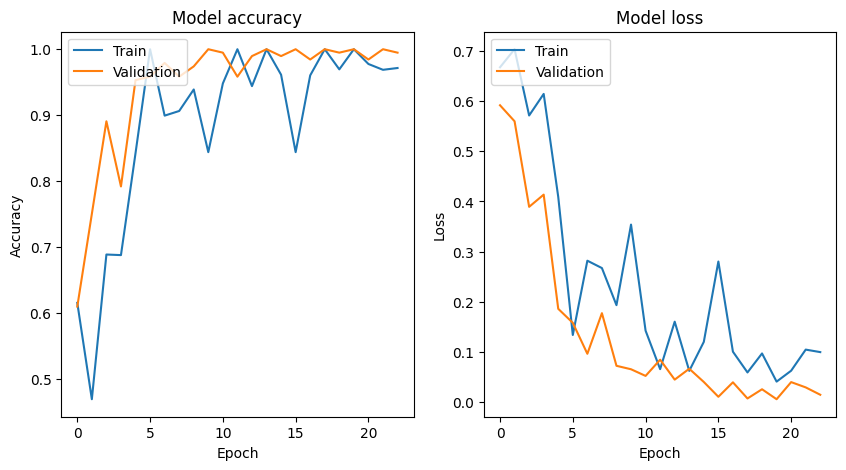

In [29]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [30]:
test_loss, test_acc = model.evaluate(test_data)
print(f'Test accuracy: {test_acc}')

#classification_report
from sklearn.metrics import classification_report
import numpy as np
y_pred = model.predict(test_data)
y_pred = (y_pred > 0.5).astype(int) # Convert probabilities to class labels (0 or 1)
y_true = test_data.classes
print(classification_report(y_true, y_pred))

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.9932 - loss: 0.0161
Test accuracy: 0.9954954981803894
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       135
           1       0.99      1.00      0.99        87

    accuracy                           1.00       222
   macro avg       0.99      1.00      1.00       222
weighted avg       1.00      1.00      1.00       222



7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step
[[134   1]
 [  0  87]]


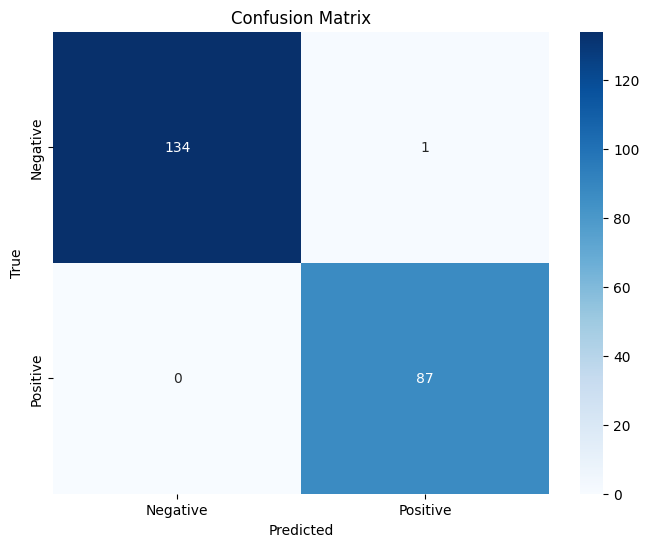

In [31]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Predict on the test data
y_pred = model.predict(test_data)
y_pred = (y_pred > 0.5).astype(int) # Convert probabilities to class labels (0 or 1)

# Get the true labels
y_true = test_data.classes

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)
print(cm)
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_data.class_indices.keys(),
            yticklabels=test_data.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [33]:
model.save('/content/drive/MyDrive/Best_MobileNetV2_model.keras')

In [34]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
image_path='/content/drive/MyDrive/monkey_pox-datset/MonkeyPox_Dataset/monkey pox dataset/All dataset with labels/skin_tone_6_80.jpg'
img = load_img(image_path, target_size=(224, 224))
img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

In [36]:
prediction = model.predict(img_array)
if prediction[0] > 0.5:
    print("Monkeypox", prediction[0])
else:
    print("Not Monkeypox", prediction[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
Monkeypox [0.87455446]


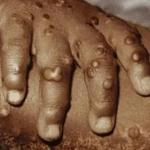

In [38]:
#opening the image
from PIL import Image
img = Image.open(image_path)
img